### Developer: Savin Shynu Varghese
#### Check out my [portfolio](https://savinshynu.github.io) and [LinkedIn](https://www.linkedin.com/in/savin-shynu-varghese-phd-data-scientist/)

## Audio Deepfake detection
### Outline
1. Motivation
2. Data Collection
3. Exploratory data analysis and visualization
4. Preprocessing
5. Model development
6. Model Evaluation

### Motivation: 
Deepfake audio represents a significant social problem due to its potential to deceive, manipulate, and harm individuals, organizations, and society at large. Deepfake audio can imitate someone's voice with high accuracy, undermining voice-based authentication systems used in banking, customer service, and other areas. This can lead to distrust in communications, spreading disinformation causing political conflicts, financial scams and many other issues. 

In this project, I have developed deep learning based models to detect different types of deepfake audio data that are prevalent today.

###  Data Collection
For this work, I have utilized the ASVSpoof 2019 English dataset which is widely used in many scientific publications for developing new algorithms to detect deepfake audio. The dataset is divided into training, development and validation folders. We will explore each of these datasets later. Each of these datasets contain the audio data from different speakers and spoofing methods.

The dataset for this work is stored in the dagshub repository: "Omdena/BangladeshChapter_Audiosheild" under this [link](https://dagshub.com/Omdena/BangladeshChapter_AudioShield/src/main/s3:/BangladeshChapter_AudioShield/data).
We can mount the data directly from the dagshub into google collab, but working in this manner is slow. For the purpose of this notebook, I have collected the data from the dagshub repo and stored on my local machine for faster processing. 

Data from the dagshub can be mounted in google collab this way:

1. install dagshub: **%pip install -q dagshub**

2. Mounting the repository :
      
    **import dagshub.colab**
   
    **repo=dagshub.colab.login()**

2. Mount path: **path=dagshub.storage.mount('Omdena/BangladeshChapter_AudioShield')**

### Exploratory Data Analysis and Visualization
Let's explore the dataset to understand the content in terms of the raw data and their annotations.

In [4]:
# data directory
data_dir = '/Users/savin/Omdena-Projects/AudioShield/data_train/'

%ls /Users/savin/Omdena-Projects/AudioShield/data_train/

ASVspoof2019_LA_asv_protocols/ ASVspoof2019_LA_eval/
ASVspoof2019_LA_asv_scores/    ASVspoof2019_LA_train/
ASVspoof2019_LA_cm_protocols/  README.LA.txt
ASVspoof2019_LA_dev/


As we can see here, there are 3 folders containing the training, development(validation) and evaluation (test) datasets. The ASVspoof2019_LA_cm_protocols folder contains the metadata labelings of the each dataset.

***output of linux commands 'ls' and 'cat' are cleared to reduce the size of the jupyter notebooks***

In [6]:
# The output has been cleared to reduce the size of this notebook
%ls /Users/savin/Omdena-Projects/AudioShield/data_train/ASVspoof2019_LA_cm_protocols

ASVspoof2019.LA.cm.dev.trl.txt    ASVspoof2019.LA.cm.train.trn.txt
ASVspoof2019.LA.cm.eval.trl.txt


In [ ]:
#Listing the contents of the training file in the protocol folder
%cat /Users/savin/Omdena-Projects/AudioShield/data_train/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt

In [97]:
%cat /Users/savin/Omdena-Projects/AudioShield/data_train/README.LA.txt

ASVspoof 2019: The 3rd Automatic Speaker Verification Spoofing and Countermeasures Challenge database

Logical access (LA)


1. Directory Structure
_______________________

  --> LA  
          --> ASVspoof2019_LA_asv_protocols
          --> ASVspoof2019_LA_asv_scores
	  --> ASVspoof2019_LA_cm_protocols
          --> ASVspoof2019_LA_dev
          --> ASVspoof2019_LA_eval
	  --> ASVspoof2019_LA_train
	  --> README.LA.txt


2. Description of the audio files
_________________________________

   ASVspoof2019_LA_train, ASVspoof2019_LA_dev, and ASVspoof2019_LA_eval contain audio files for training, development, and evaluation
   (LA_T_*.flac, LA_D_*.flac, and LA_E_*.flac, respectively). ASVspoof2019_PA_dev, and ASVspoof2019_PA_eval contain audio files to enroll ASV system. The audio files in the directories are in the flac format. 
   The sampling rate is 16 kHz, and stored in 16-bit.


3. Description of the protocols
_______________________________

CM protocols:

   ASVspoof2019_LA_cm_pro

In [ ]:
# Listing a small list of files in the training folder
%ls /Users/savin/Omdena-Projects/AudioShield/data_train/ASVspoof2019_LA_train/flac/LA_T_1*

We can see all the audio files in the .flac format here. FLAC (Free Lossless Audio Codec) is an audio coding format for lossless compression of digital audio. We can start to read some audio files from the train folder and do some visualization.

In [11]:
import glob
import numpy as np
import librosa
import librosa.display
from matplotlib import pyplot as plt
import IPython.display as ipd


# Audio data in the training, dev and eval  folder
train_fold = data_dir+'ASVspoof2019_LA_train/flac/*.flac'
dev_fold = data_dir+'ASVspoof2019_LA_dev/flac/*.flac'
eval_fold = data_dir+'ASVspoof2019_LA_eval/flac/*.flac'

# audio files
train_files = sorted(glob.glob(train_fold))
dev_files = sorted(glob.glob(dev_fold))
eval_files = sorted(glob.glob(eval_fold))

print(f"No. of audio files in the training folder: {len(train_files)}")
print(f"No. of audio files in the dev folder: {len(dev_files)}")
print(f"No. of audio files in the eval folder: {len(eval_files)}")

No. of audio files in the training folder: 25380
No. of audio files in the dev folder: 24986
No. of audio files in the eval folder: 71933


For the moment, let's concentrate on the data from the training folder. For the display of audio files, we will import 2 libraries here. Librosa is widely used to handle the audio data files.

### Time Domain and Frequency domain visualization
1. Time series
2. Spectrogram
3. Mel spectrograms

First we will look at the audio time series which is power plotted as a function of time. From the Fourier analysis, we know that each time series can be decomposed into it's frequency components using Fourier transform. This will allow us to undestand how much of a frequency content is present in each signal. If the signal frequency content is stationary, we can conduct a discrete Fourier transform. If the frequency inforamtion changes as a function of time, then we can divide the time series into short time segments and calculate their corresponing fourier transform to get a spectrogram (2D array of frequency and time). 

Sample length: (55134,) and the sample rate: 22050, duration :2.500s


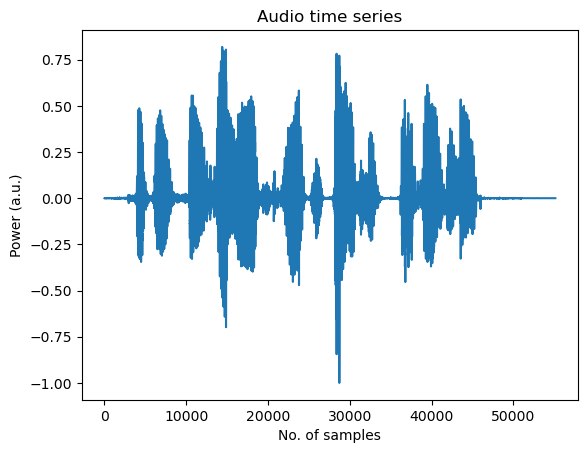

In [14]:
# play the first audio file
ipd.Audio(train_files[0])

# Load a sample audio file as a time series and the sample rate of the audio
y, sr = librosa.load(train_files[0])

print(f"Sample length: {y.shape} and the sample rate: {sr}, duration :{y.shape[0]/sr:0.3f}s")

# Let's plot the audio time series
plt.plot(y)
plt.xlabel("No. of samples")
plt.ylabel("Power (a.u.)")
plt.title("Audio time series")
plt.show()

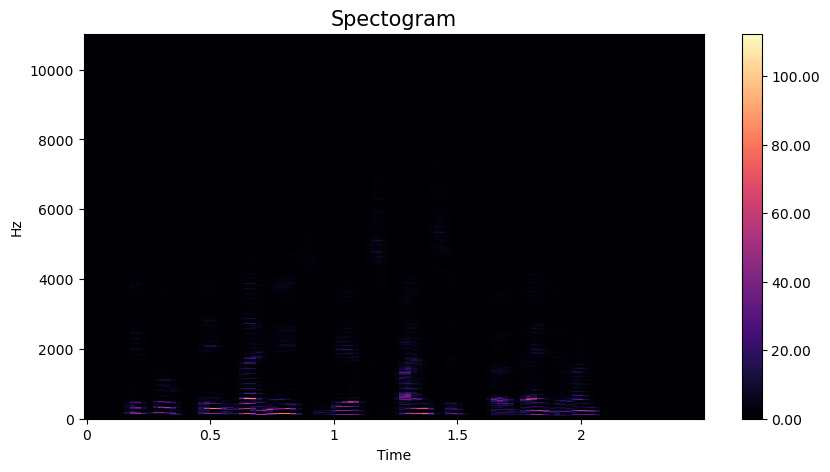

In [15]:
# Now let's plot a spectrogram
# for this we will use an FFT with a window length of 2048 samples, hop_length = fft_size/4 which is the distance 
# between adjacent fft windows. The time segments can be overlapping to measure the change in the frequency component.

S = np.abs(librosa.stft(y, n_fft=2048, hop_length = 512)) # taking the amplitude of the FFT output
#plt.imshow(S, cmap='jet', aspect='auto', origin='lower')
#plt.show()

# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S,
                              x_axis='time',
                              y_axis='hz',
                              ax=ax)
ax.set_title('Spectogram', fontsize=15)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()


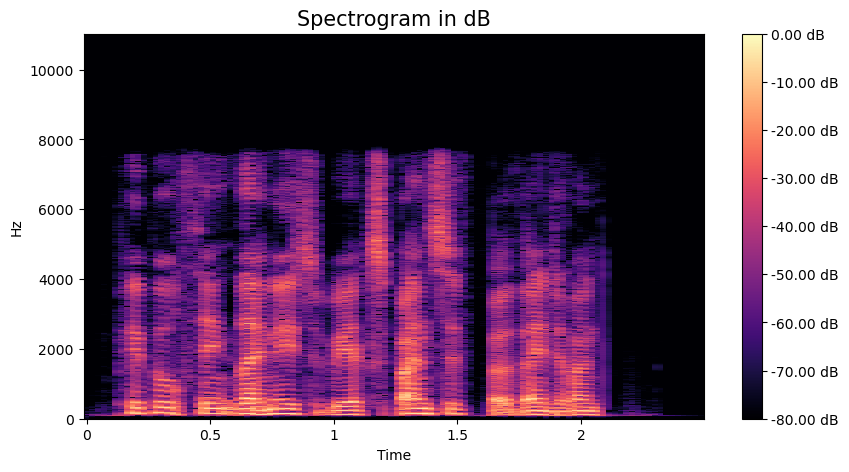

In [16]:
# Let's look at the spectrogram in decibels
S_db = librosa.amplitude_to_db(S, ref=np.max)

# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='hz',
                              ax=ax)
ax.set_title('Spectrogram in dB', fontsize=15)
fig.colorbar(img, ax=ax, format=f'%0.2f dB')
plt.show()

### Mel Spectrogram
All the frequnecy and time components can be clearly seen with the decibel units. Now let's see how the mel spectrogram looks like. Mel spectrogram is a spectrogram with its frequencies converted to Mel scale or basically in a log scale. For human beings, it is easy to understand the difference between frequencies at low frequencies than the high frequencies. Mel scale was introduced so that equal distance in pitch/frequency will sound equally distant to the listner.
This can be easily computed using the "librosa.feature.melspectrogram" function. The input can be either a time series or a spectrogram. If given a time series, we need to specify the length of FFT and the overlap between time segments to calculate an STFT first. Let's do it directly from the time series as we will carry out that approach.

Mel spectrogram shape: (128, 87)


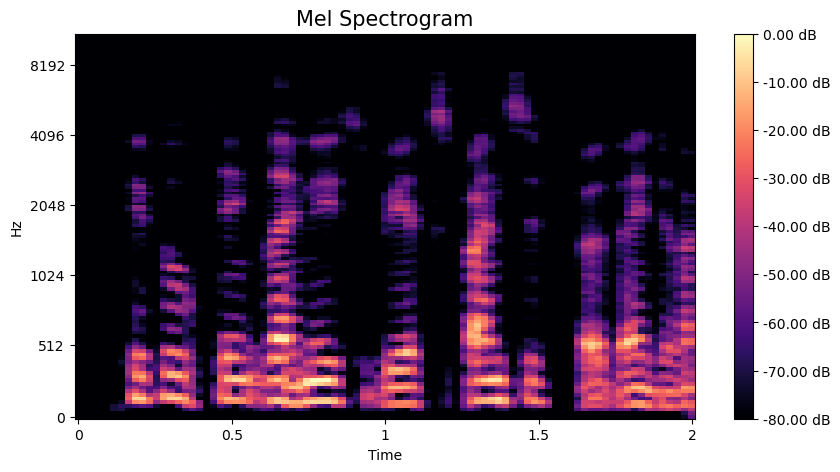

In [18]:
#S_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128 * 2)

# Reading 2 seconds of data
S_mel = librosa.feature.melspectrogram(y=y[:int(sr*2.0)], sr=sr, n_mels=128)
S_db_mel = librosa.amplitude_to_db(S_mel, ref=np.max)

print(f"Mel spectrogram shape: {S_db_mel.shape}")
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='mel',
                              ax=ax)
ax.set_title('Mel Spectrogram', fontsize=15)
fig.colorbar(img, ax=ax, format=f'%0.2f dB')
plt.show()

77166
Mel spectrogram shape: (128, 259)


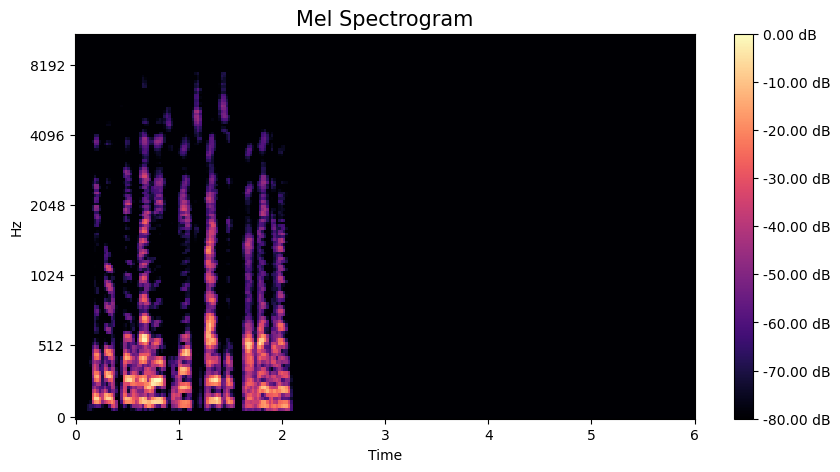

In [19]:
# Let's look at the spectrogram if we do not have enough data
# the audio file that we are working with only has 3.5 seconds of data, but let'say we uniformly want to load 6 seconds of data,
# we have to pad rest of the data with zeros.

# no. of samples to pad on the right
pad_right = int(sr*6.0 - y.shape[0])
print(pad_right)
ynew = np.pad(y, (0, pad_right))

# Reading 2 seconds of data
S_mel = librosa.feature.melspectrogram(y=ynew, sr=sr, n_mels=128)
S_db_mel = librosa.amplitude_to_db(S_mel, ref=np.max)

print(f"Mel spectrogram shape: {S_db_mel.shape}")
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='mel',
                              ax=ax)
ax.set_title('Mel Spectrogram', fontsize=15)
fig.colorbar(img, ax=ax, format=f'%0.2f dB')
plt.show()

### Data Preprocessing
For modeling the data, let's take a random equal set of bonafide and spoof data for training. For that first we need to collect the label and filename information from the text file. Once we have that we can select a random set of audio files in both categories for training the model.

In [21]:
import pandas as pd

train_filepath = '/Users/savin/Omdena-Projects/Audioshield/data_train/ASVspoof2019_LA_train/flac/'
cv_filepath = '/Users/savin/Omdena-Projects/Audioshield/data_train/ASVspoof2019_LA_dev/flac/'
test_filepath = '/Users/savin/Omdena-Projects/Audioshield/data_train/ASVspoof2019_LA_eval/flac/'

# Funciton to extract information from the text file
def get_label_info(text_file, mode):
    """
    Returns a pandas dataframe of label information
    Arguments:
    text_file: input text file with audio filename and labels
    """
    speaker_code = []
    filename = []
    spoof_code = []
    label = []
    with open(text_file,"r") as fh:
        for line in fh.readlines():
            str = line.split()
            speaker_code.append(str[0])
            
            if mode == 'train':
                filename.append(train_filepath + str[1] + '.flac') # adding the file extension for easy extraction
            elif mode == 'test':
                filename.append(test_filepath + str[1] + '.flac')
            else:
                filename.append(cv_filepath + str[1] + '.flac')
                
            spoof_code.append(str[3])
            label.append(str[4])
        fh.close()
    df = pd.DataFrame(data={'filename': filename, 'label': label, 'speaker_code': speaker_code, 'spoof_code': spoof_code})
    return df    

# Getting all train files
label_train = '/Users/savin/Omdena-Projects/Audioshield/data_train/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
df_train_ini = get_label_info(label_train, mode= 'train')
df_train_ini.head()   

# Getting all the validation files
label_cv = '/Users/savin/Omdena-Projects/Audioshield/data_train/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'
df_cv_ini = get_label_info(label_cv, mode= 'cv')

# Get the info from the text file corresponding to evaluation data
label_test = "/Users/savin/Omdena-Projects/AudioShield/data_train/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
df_test_ini = get_label_info(label_test, mode='test')

In [22]:
# Now let's get some basic info out of the dataframe
df_train_ini.describe()

,filename,label,speaker_code,spoof_code
count,25380,25380,25380,25380
unique,25380,2,20,7
top,/Users/savin/Omdena-Projects/Audioshield/data_...,spoof,LA_0089,A01
freq,1,22800,1308,3800


In [23]:
df_cv_ini.describe()

,filename,label,speaker_code,spoof_code
count,24844,24844,24844,24844
unique,24844,2,20,7
top,/Users/savin/Omdena-Projects/Audioshield/data_...,spoof,LA_0069,A01
freq,1,22296,2638,3716


As we can see for the training data, there are 25380 unique audio files, 2 classes of labels, files corresponding to 20 speakers and 7 spoof codes. Similarly for the cross validation dataset as well. Let's see what the individual categories are.

In [25]:
df_train_ini["label"].value_counts()

label
spoof       22800
bonafide     2580
Name: count, dtype: int64

In [26]:
df_train_ini["spoof_code"].value_counts()

spoof_code
A01    3800
A02    3800
A03    3800
A04    3800
A05    3800
A06    3800
-      2580
Name: count, dtype: int64

In [27]:
df_train_ini["speaker_code"].value_counts()

speaker_code
LA_0089    1308
LA_0082    1308
LA_0083    1308
LA_0096    1308
LA_0095    1308
LA_0094    1308
LA_0093    1308
LA_0092    1308
LA_0090    1243
LA_0097    1243
LA_0091    1243
LA_0079    1243
LA_0080    1243
LA_0088    1243
LA_0087    1243
LA_0086    1243
LA_0085    1243
LA_0084    1243
LA_0081    1243
LA_0098    1243
Name: count, dtype: int64

In [28]:
df_cv_ini["label"].value_counts()

label
spoof       22296
bonafide     2548
Name: count, dtype: int64

As we can see, the number of bonafide audio files in the training samples are way smaller compared to the number of spoofed files in both the training and validation dataset. The spoofed files have almost equal contributions from different spoofing techniques. 

To avoid bias during modeling of the datasets, let't take construct a dataset with equal number of bonafide and spoofed files randomly sampled from the list we have. Also, we can sample some random 1500 files from the cross validation and merge it with the training data so that the model can learn the features of the bonafide data well.

Let's combine the spoof list and bonafide list to make a single list which can be used to create a training set and cross validation set

In [31]:
def collect_list(df, nbon, nspoof):
    """
    Function to collect a specified amount of bonafide and spoof samples 
    from the list

    Returns:
    A pandas dataframe with containing the list of bonafide and spoof samples

    Args:
    nbon: number of bonafide samples
    nspoof: number of spoof samples
    """
    # Get a list of bon dat
    bon_dat = df[df['label']=='bonafide'][["filename", "label"]]
    
    # Get a random sample of the spoofed data from the list
    spoof_dat = df[df['label']=='spoof'][["filename", "label"]]

    bon_len = bon_dat.shape[0]
    spoof_len = spoof_dat.shape[0]

    print(f" Requested bonafide:{nbon}, Actual bonafide: {bon_len}, Requested spoof:{nspoof}, Actual spoof:{spoof_len}")

    if nbon < bon_len:
        bon_dat = bon_dat.sample(nbon, axis=0, random_state=42)
    else:
        print("Getting all bonafide as requested number greater than existing number of samples")
    
    if nspoof < spoof_len:
        spoof_dat = spoof_dat.sample(nspoof, axis=0, random_state=42)
    else:
        print("Getting all spoof as requested number greater than existing number of samples")

    # concatenating data frames and shuffling them
    df_con = pd.concat([bon_dat, spoof_dat]).sample(frac=1,random_state = 42)

    # replacing categorical values with the numerics
    df_con['label'] = df_con['label'].replace({'bonafide' : 0 , 'spoof' : 1})

    return df_con

In [32]:
df_train = collect_list(df_train_ini, nbon=2580, nspoof=4000)
df_train['filename'].value_counts()
df_train['label'].value_counts()
#df_train.head()

 Requested bonafide:2580, Actual bonafide: 2580, Requested spoof:4000, Actual spoof:22800
Getting all bonafide as requested number greater than existing number of samples


label
1    4000
0    2580
Name: count, dtype: int64

In [33]:
# Getting all bonafide samples from development set
df_cv_bon = collect_list(df_cv_ini, nbon=2548, nspoof=0)
df_cv_bon['label'].value_counts()

 Requested bonafide:2548, Actual bonafide: 2548, Requested spoof:0, Actual spoof:22296
Getting all bonafide as requested number greater than existing number of samples


label
0    2548
Name: count, dtype: int64

Now let's use the first 1000 for training and remaining 1580 for cross validation.

In [35]:
# concatenate existing train and first 1000 bonafide samples from the development set and shuffle to form a new train set
df_train = pd.concat([df_train, df_cv_bon.iloc[:1000,:]]).sample(frac=1,random_state = 42)
#df_train.head()
df_train['label'].value_counts()

label
1    4000
0    3580
Name: count, dtype: int64

Now we have a total of 3580 bonafide and 4000 spoof audio samples for training. Let's collect an equal set of 1580 bonafide and spoof samples for cross validation as well. For this we will use the last 1580 bonafide samples and random 1580 spoof samples from the development set.

In [37]:
df_cv_spoof = collect_list(df_cv_ini, nbon=0, nspoof=1600)
df_cv =  pd.concat([df_cv_spoof, df_cv_bon.iloc[1000:,:]]).sample(frac=1,random_state = 42)
df_cv['label'].value_counts()

 Requested bonafide:0, Actual bonafide: 2548, Requested spoof:1600, Actual spoof:22296


label
1    1600
0    1548
Name: count, dtype: int64

####  Feature extraction
Now we will extract the Mel spectrogram for all the training and CV audio files. But before that we have to make sure that the array dimensions of all the mel spectrograms are the same for feeding into CNN model. For that we need to investigate the duration of all the train and test files.

In [39]:
# Let's get the duration of all the files

def get_duration(df):
    """
    Function to get the duration of all the audio files
    in the pandas data frame
    Returns: durations, numpy array
    argument:
    df : input pandas data frame
    """
    info = np.zeros(df.shape)
    for i in range(df.shape[0]):
        filename = df.iloc[i,0]
        y, sr = librosa.load(filename)
        info[i,:] = [y.shape[0]/sr, sr]
    return info

# Get the duration of all the files in the final data frame
info = get_duration(df_train)
dur_files = info[:,0] # durations
sr_files = info[:,1]  # sample rates

print("Statistics of spoof and bonafide data")
print(f"Minimum: {dur_files.min():0.3f}, Maximum: {dur_files.max():0.3f}, Average: {dur_files.mean():0.3f}, 95 percentile: {np.percentile(dur_files, 95):0.3f}")
print(f"Sample rate Minimum: {sr_files.min():0.3f}, Maximum: {sr_files.max():0.3f}, Average: {sr_files.mean():0.3f}")

Statistics of spoof and bonafide data
Minimum: 0.698, Maximum: 11.838, Average: 3.413, 95 percentile: 5.706
Sample rate Minimum: 22050.000, Maximum: 22050.000, Average: 22050.000


The minimum duration is 0.7 seconds and the maximum is 11 seconds for the whole dataset. Since we have only limited data for bonafide samples, we have to make sure that we get the maximum bonafide data for training. Here 95% of observations of bonafide samples are smaller than 5 seconds and this is close to 6 seconds for the whole dataset.

So let's load 6 seconds of samples for feature extraction.

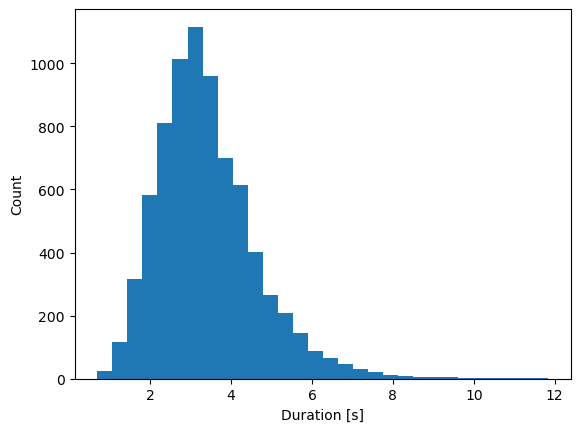

In [41]:
# plot a histogram of the durations
plt.hist(dur_files, 30)
plt.ylabel("Count")
plt.xlabel("Duration [s]")
plt.show()

Let's load 6 seconds of data from each audio file. If the audiofile does not have that many data, we will pad the rest of the data with zeros.

####  Collecting the train and cross validation data
We have already sampled the dataframe for training and cross validation from which we will load 6 seconds of data from each audio file, convert it into a mel spectrogram and store it as an array. 

In [44]:
# Grid size of Mel spectrogram for reading 6 seconds of data
ntime = 259
nfreq = 128

# Initializing the array to save the mel spectrograms
X_train = np.zeros((df_train.shape[0], nfreq, ntime, 1))
Y_train = df_train['label']

X_cv = np.zeros((df_cv.shape[0], nfreq, ntime, 1))
Y_cv = df_cv['label']

# Now let's load the load first 6 seconds of the audio files into the train and CV data
def load_mel(df, data):
    """
    Load audio file, extract spectrogram and store them in a numpy array
    Returns spectrogram matrix
    arguments:
    df: data frame containing file info
    data : data array, numpy array
    """
    for i in range(df.shape[0]):
        #print(df.iloc[i,0], df.iloc[i,2], df.iloc[i,2])
        ydat, samp_rate = librosa.load(df.iloc[i,0])
        
        # no. of samples to pad on the right, if data less than 6 seconds
        pad_right = int(samp_rate*6.0 - ydat.shape[0])
        
        if pad_right > 0 :
            ydat = np.pad(ydat, (0, pad_right)) # padding on the right for shorter audio files
        else:
            ydat = ydat[:int(samp_rate*6.0)] # truncating at 6 seconds for longer duration files
        
        # inputing 6 seconds of time series for spectrogram extraction
        S_mel = librosa.feature.melspectrogram(y=ydat, sr=samp_rate, n_mels=128)
        S_mel_db = librosa.amplitude_to_db(S_mel, ref=np.max)
        # Min max normalizing before loading the dataset
        data[i,:,:, 0] = (S_mel_db - S_mel_db.min())/(S_mel_db.max() - S_mel_db.min())    

In [45]:
# Load mel spectrograms
load_mel(df_train, X_train)
load_mel(df_cv, X_cv)

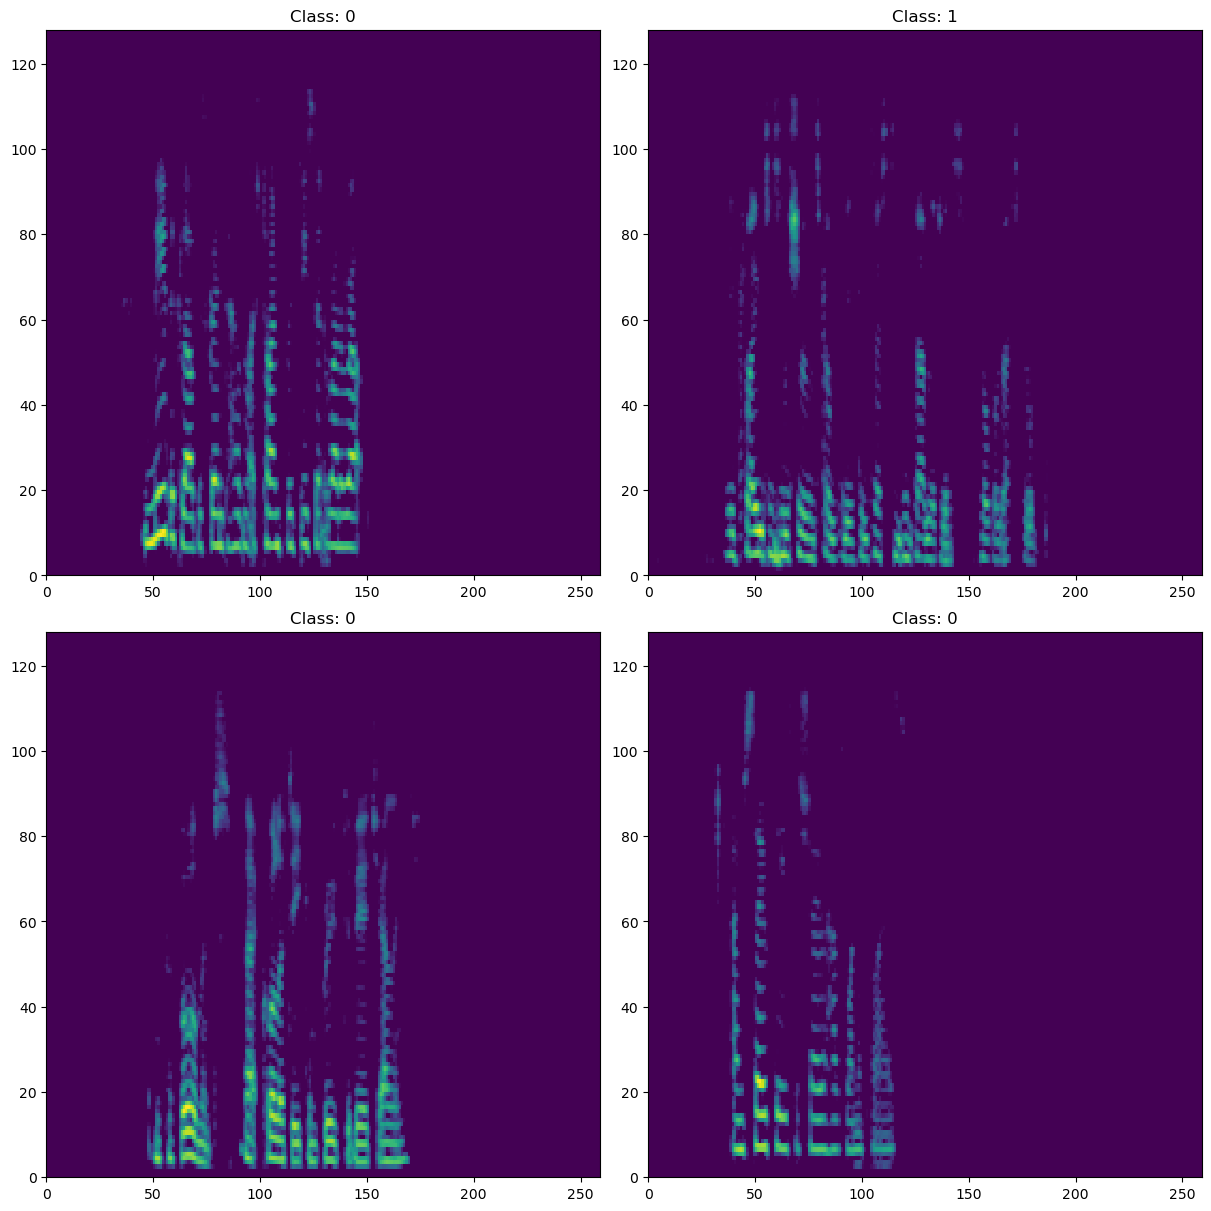

In [72]:
# Now let's plot the some of the first real and fake data
fig, axs = plt.subplots(2,2, constrained_layout=True, figsize = (12,12))
for i in range(2):
    for j in range(2):
        num = i*4+j
        img = X_train[num,:,:, 0]
        axs[i,j].pcolormesh(img)
        axs[i,j].set_title(f"Class: {Y_train.iloc[num]}")
plt.show()

The data has been loaded into the X_train and X_cv arrays. Now let's do the modeling of the data.

### Modeling the data
For modeling the data, we will try 2 different variants of the convolutional neural network (CNN), First we will start with a simpler CNN model and see how the network trains the data. Then we will use a complicated ResNet architecture and see how that improves the classification results.

#### Simple CNN architecture

In [250]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Input

input_shape = X_train.shape[1:]
# Let's build a CNN model of this form
# Input >> ConV2D << Maxpool << Conv2D <<  Maxpool <<  ConV2D << Maxpool << Conv2D << Maxpool << Flatten << Dense << Dense << Dense (sigmoid)
simple_cnn = Sequential([
    Input(shape=input_shape),
    Conv2D(filters=32, kernel_size=3, strides=(1,1), activation='relu', padding='valid', name = 'conv1'), 
    MaxPool2D(pool_size=(4, 4), strides=(2,2), name = 'pool1'),
    Conv2D(filters=64, kernel_size=3, strides=(1,1), activation='relu', padding='valid', name = 'conv2'), 
    MaxPool2D(pool_size=(3, 3), strides=(2,3), name = 'pool2'),
    Conv2D(filters=128, kernel_size=5, strides=(1,1), activation='relu', padding='valid', name = 'conv3'),
    MaxPool2D(pool_size=(2, 2), strides=(2,2), name = 'pool3'),
    Conv2D(filters=256, kernel_size=3, strides=(1,1), activation='relu', padding='valid', name = 'conv4'),          
    MaxPool2D(pool_size=(2, 2), strides=(2,2), name = 'pool4'),
    Flatten(name = 'Flat'),
    Dense(64, activation='relu', name='Dense1'),
    Dense(16, activation='relu', name='Dense2'),
    Dense(1, activation='sigmoid', name='output' )])

simple_cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
simple_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 126, 257, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 62, 127, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 60, 125, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 29, 41, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 25, 37, 128)       204928    
                                                                 
 pool3 (MaxPooling2D)        (None, 12, 18, 128)       0         
                                                                 
 conv4 (Conv2D)              (None, 10, 16, 256)      

In [252]:
#Let's train the model now
history = simple_cnn.fit(X_train, Y_train, epochs=15, batch_size=64, validation_data=(X_cv, Y_cv))

Epoch 1/15
119/119 [==============================] - 118s 981ms/step - loss: 0.5001 - accuracy: 0.7263 - val_loss: 0.4836 - val_accuracy: 0.7602
Epoch 2/15
119/119 [==============================] - 118s 988ms/step - loss: 0.4143 - accuracy: 0.7997 - val_loss: 0.3809 - val_accuracy: 0.8281
Epoch 3/15
119/119 [==============================] - 117s 980ms/step - loss: 0.2396 - accuracy: 0.8995 - val_loss: 0.2185 - val_accuracy: 0.9095
Epoch 4/15
119/119 [==============================] - 116s 974ms/step - loss: 0.1485 - accuracy: 0.9427 - val_loss: 0.2082 - val_accuracy: 0.9161
Epoch 5/15
119/119 [==============================] - 116s 973ms/step - loss: 0.0949 - accuracy: 0.9661 - val_loss: 0.2108 - val_accuracy: 0.9276
Epoch 6/15
119/119 [==============================] - 115s 967ms/step - loss: 0.0618 - accuracy: 0.9786 - val_loss: 0.1332 - val_accuracy: 0.9539
Epoch 7/15
119/119 [==============================] - 116s 975ms/step - loss: 0.0425 - accuracy: 0.9872 - val_loss: 0.2076 -

That's pretty good. The history dictionary has the loss and accuray of the model on the training and validation data. Let's convert these dictionaries into a pandas data frame and plot them up.

/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_79498/977494173.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_79498/977494173.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

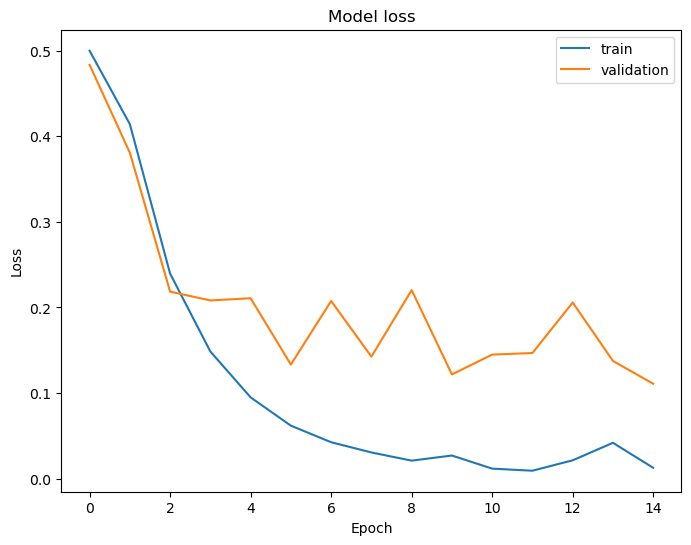

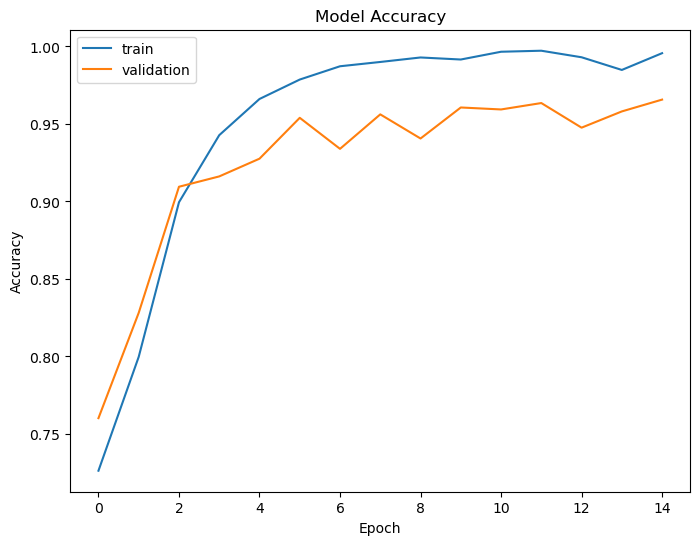

In [258]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)

# losses data frame
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)

# accuracy data frame
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)

# plotting the loss and accuracy
df_loss.plot(title='Model loss',figsize=(8,6)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(8,6)).set(xlabel='Epoch',ylabel='Accuracy')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

ypred_train_cnn = simple_cnn.predict(X_train)
ypred_train_cnn[ypred_train_cnn>0.5] = 1
ypred_train_cnn[ypred_train_cnn<0.5] = 0

ypred_cv_cnn = simple_cnn.predict(X_cv)
ypred_cv_cnn[ypred_cv_cnn>0.5] = 1
ypred_cv_cnn[ypred_cv_cnn<0.5] = 0

print("Training data:")
print(f" Precision : {precision_score(Y_train, ypred_train_cnn)}, Recall: {recall_score(Y_train, ypred_train_cnn)},F1-score:{f1_score(Y_train, ypred_train_cnn)}")

print("CV data:")
print(f" Precision : {precision_score(Y_cv, ypred_cv_cnn)}, Recall: {recall_score(Y_cv, ypred_cv_cnn)}, F1-score:{f1_score(Y_cv, ypred_cv_cnn)}")



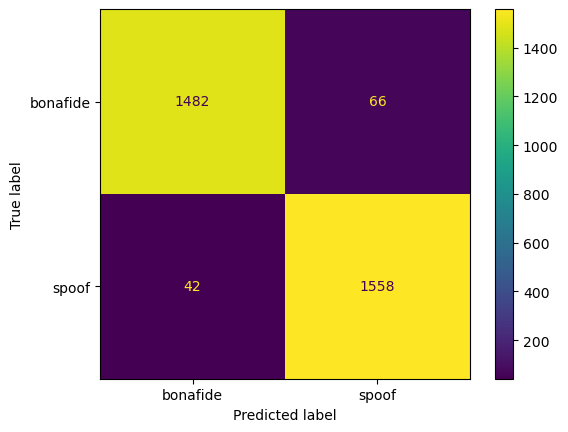

In [264]:
# Confusion matrix from the CV data
ConfusionMatrixDisplay.from_predictions(Y_cv, ypred_cv_cnn, display_labels = ['bonafide','spoof'])
plt.show()

In [268]:
# Let's look at the classification report
from sklearn.metrics import classification_report
print(classification_report(Y_cv, ypred_cv_cnn, target_names=['bonafide', 'spoof']))

              precision    recall  f1-score   support

    bonafide       0.97      0.96      0.96      1548
       spoof       0.96      0.97      0.97      1600

    accuracy                           0.97      3148
   macro avg       0.97      0.97      0.97      3148
weighted avg       0.97      0.97      0.97      3148



The model is performing well on the cross validation data with close 0.96 f1 score for bonafide and 0.97 for the spoof class.

In [308]:
# Let's save the model to an h5 format
simple_cnn.save("simple-cnn-ssv.h5")

In [36]:
# saving the model as pickle file. But tensorflow recommends saving as .h5 files
#import joblib
#joblib.dump(simple_cnn, filename="simple-cnn-ssv.pkl")

### ResNet50 Architecture
ResNet is a deep CNN network with residual blocks. Each of these residual blocks has a skip connection or shortcut connection enabling the better flow of gradient within network solving vanishing gradient issue. This will reduce the training error as the networks become deeper compared to the plain networks. Each of these residual block has the capability to learn an identity function. So adding them will not harm the network and will be able to understand complex functions.

For the ease of purpose, rather than building a model from scratch, we will import the ResNet50 architecture from tensorflow. Here we cannot conduct a transfer learning because the resnet model was trained on images with 3 channels and we have only 1 channel for the spectrogram. So we cannot use the weights trained on the imagenet. If we were using real life images with 3 channels, then we could have used the weights from imagenet training and utilized a transfer learning approach. However, in our case the inputs are spectrograms and we need to train our model from the scratch for this purpose.

In [82]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50

# Let's start building the ResNet50 model

def build_resnet(input_shape):

    # Calling the base model
    base_model = ResNet50(
    include_top=False, # remove the top layer or the classification layer.
    weights=None, # randomly initialize weights
    input_tensor=None,
    input_shape=input_shape,
    pooling=None)  # no pooling mentioned

    #print a summary of the base model
    base_model.summary()

    nb_layers = len(base_model.layers)
    print(f"No. of base model layers: {nb_layers}")

    # UnFreeze the base model by making it trainable, keep it False if want to freeze the hidden layers
    # We need to train the base model since we are not using the imagene weights
    base_model.trainable = True

    # Calling the input layer
    x_input = Input(input_shape)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x_input, training=True)

    # use global avg pooling to summarize the info in each channel
    x = GlobalAveragePooling2D()(x) 
    
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2)(x)

    x = Dense(units=512, activation='relu')(x)

    x = Dense(units=16, activation='relu')(x)

    # Final output layer
    x = Dense(units=1, activation='sigmoid')(x)
    res_model = Model(inputs=x_input, outputs=x)

    return res_model

input_shape = X_train.shape[1:]
res_cnn = build_resnet(input_shape)

res_cnn.summary()
for layer in res_cnn.layers:
    print(layer)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 259, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 265, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 130, 64)  3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 130, 64)  256         ['conv1_conv[0][0]']      

In [ ]:
res_cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
hist_res = res_cnn.fit(X_train, Y_train, epochs=8, batch_size=64, validation_data=(X_cv, Y_cv))

Epoch 1/8
119/119 [==============================] - 1057s 9s/step - loss: 0.4414 - accuracy: 0.7984 - val_loss: 0.2864 - val_accuracy: 0.8663
Epoch 2/8
119/119 [==============================] - 1083s 9s/step - loss: 0.1799 - accuracy: 0.9297 - val_loss: 0.1559 - val_accuracy: 0.9425
Epoch 3/8
119/119 [==============================] - 1069s 9s/step - loss: 0.1069 - accuracy: 0.9604 - val_loss: 0.0930 - val_accuracy: 0.9638
Epoch 4/8
119/119 [==============================] - 1056s 9s/step - loss: 0.0801 - accuracy: 0.9728 - val_loss: 0.1225 - val_accuracy: 0.9562
Epoch 5/8
119/119 [==============================] - 1058s 9s/step - loss: 0.0852 - accuracy: 0.9711 - val_loss: 0.0988 - val_accuracy: 0.9638
Epoch 6/8
 11/119 [=>............................] - ETA: 14:03 - loss: 0.0440 - accuracy: 0.9901

/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_79498/3358801200.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_79498/3358801200.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

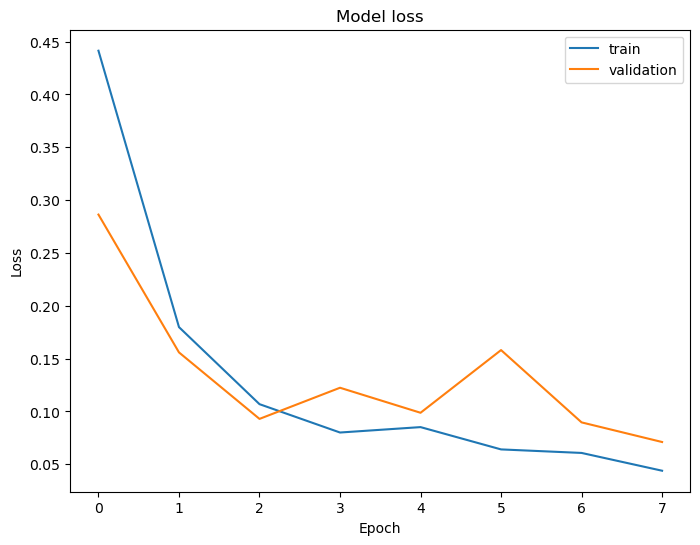

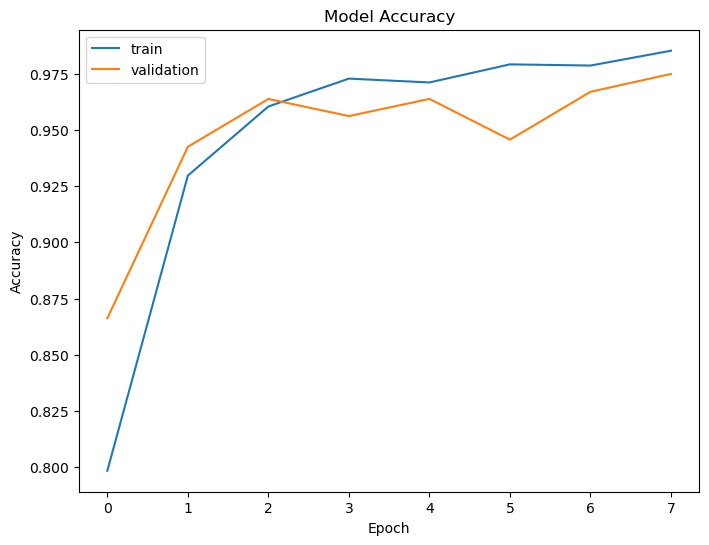

In [299]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(hist_res.history)

# losses data frame
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)

# accuracy data frame
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)

# plotting the loss and accuracy
df_loss.plot(title='Model loss',figsize=(8,6)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(8,6)).set(xlabel='Epoch',ylabel='Accuracy')

In [301]:
ypred_train_res = res_cnn.predict(X_train)
ypred_train_res[ypred_train_res>0.5] = 1
ypred_train_res[ypred_train_res<0.5] = 0

ypred_cv_res = res_cnn.predict(X_cv)
ypred_cv_res[ypred_cv_res>0.5] = 1
ypred_cv_res[ypred_cv_res<0.5] = 0

print("Training data:")
print(f" Precision : {precision_score(Y_train, ypred_train_res)}, Recall: {recall_score(Y_train, ypred_train_res)},F1-score:{f1_score(Y_train, ypred_train_res)}")

print("CV data:")
print(f" Precision : {precision_score(Y_cv, ypred_cv_res)}, Recall: {recall_score(Y_cv, ypred_cv_res)}, F1-score:{f1_score(Y_cv, ypred_cv_res)}")


99/99 [==============================] - 96s 969ms/step
Training data:
 Precision : 0.9890329012961117, Recall: 0.992,F1-score:0.9905142286570146
CV data:
 Precision : 0.9679210363972857, Recall: 0.980625, F1-score:0.9742316050915865


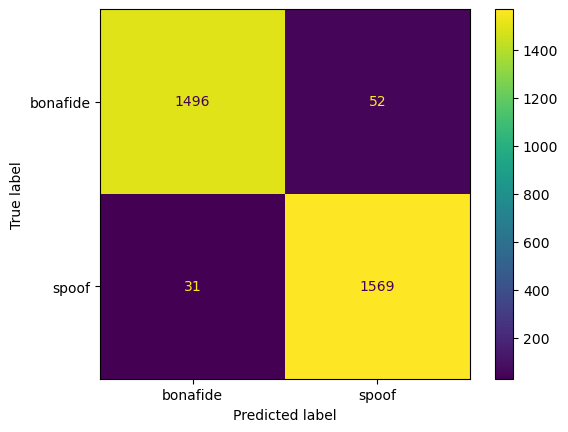

In [303]:
# Confusion matrix from the CV data
ConfusionMatrixDisplay.from_predictions(Y_cv, ypred_cv_res, display_labels = ['bonafide','spoof'])
plt.show()

In [305]:
# Let's look at the classification report
from sklearn.metrics import classification_report
print(classification_report(Y_cv, ypred_cv_res, target_names=['bonafide', 'spoof']))

              precision    recall  f1-score   support

    bonafide       0.98      0.97      0.97      1548
       spoof       0.97      0.98      0.97      1600

    accuracy                           0.97      3148
   macro avg       0.97      0.97      0.97      3148
weighted avg       0.97      0.97      0.97      3148



From the Resnet architecture modeling, we can see that the precision, recall and F1 score have improved and gives better results compared to the simplified CNN model. The Resnet model was only trained for 8 epochs because of the computational expenses. The model could definitely do better if it was trained for more epochs. Anyways, the misclassification has reduced a lot using the Resnet model.

In [311]:
# Let's save the model to an h5 format
res_cnn.save("res-cnn-ssv.h5")

###  Evaluation of simple CNN and ResNet architecture on equal amount spoof and bonafide test data

In [ ]:
%cat /Users/savin/Omdena-Projects/AudioShield/data_train/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt

The evaluation data has a good mix of bonafide and spoof data in it. Let's take 2000 sample of bonafide and spoof audio files to test the performance of both models on the unseen dta. Before that let's delete the train and CV data in memory as we have already saved the models.

In [316]:
# deleting the big data arrays
del X_train
del X_cv

In [346]:
# Let's evalulate the model on an equal number of bonafide and spoof samples first.
df_test_eq = collect_list(df_test_ini, nbon=2000, nspoof=2000)
df_test_eq['label'].value_counts() 
#df_test_eq.head()

 Requested bonafide:2000, Actual bonafide: 7355, Requested spoof:2000, Actual spoof:63882


label
0    2000
1    2000
Name: count, dtype: int64

Now let's load the files for training

In [324]:
# loading the audio files for training
X_test_eq = np.zeros((df_test_eq.shape[0], nfreq, ntime, 1))
Y_test_eq = df_test_eq['label']
load_mel(df_test_eq, X_test_eq)

### Simplified CNN results on balanced dataset

125/125 [==============================] - 16s 128ms/step


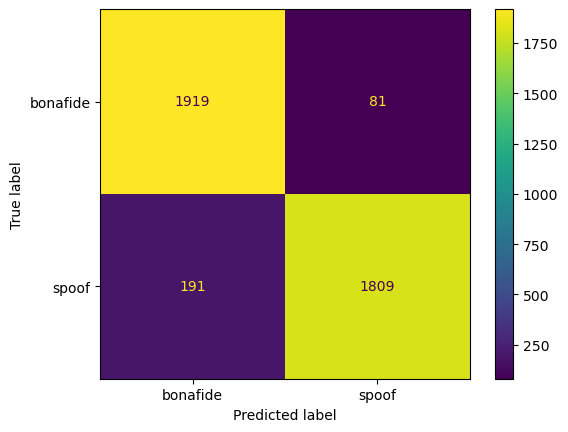

In [336]:
# lets' look at the results from the test set

ypred_test_eq = simple_cnn.predict(X_test_eq)
ypred_test_eq[ypred_test_eq>0.5] = 1
ypred_test_eq[ypred_test_eq<0.5] = 0

# Confusion matrix from the test data
ConfusionMatrixDisplay.from_predictions(Y_test_eq, ypred_test_eq, display_labels = ['bonafide', 'spoof'])
plt.show()

In [329]:
# Let's look at the classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test_eq, ypred_test_eq, target_names=['bonafide', 'spoof']))

              precision    recall  f1-score   support

    bonafide       0.91      0.96      0.93      2000
       spoof       0.96      0.90      0.93      2000

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



On a balanced unseen data, the simplified **CNN model is acheiving 0.93 f1-score for both classes** which is good.

### ResNet results on balanced dataset

125/125 [==============================] - 123s 978ms/step


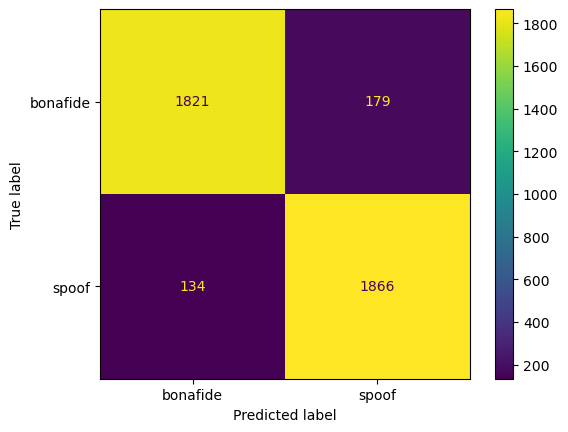

In [334]:
# lets' look at the results from the test set

ypred_test_eq_res = res_cnn.predict(X_test_eq)
ypred_test_eq_res[ypred_test_eq_res>0.5] = 1
ypred_test_eq_res[ypred_test_eq_res<0.5] = 0

# Confusion matrix from the test data
ConfusionMatrixDisplay.from_predictions(Y_test_eq, ypred_test_eq_res, display_labels = ['bonafide', 'spoof'])
plt.show()

In [340]:
# Let's look at the classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test_eq, ypred_test_eq_res, target_names=['bonafide', 'spoof']))

              precision    recall  f1-score   support

    bonafide       0.93      0.91      0.92      2000
       spoof       0.91      0.93      0.92      2000

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



On unseen test data, **ResNet is giving 0.92 f1-score** on both bonafide and spoof classes. Even though, ResNet performance is slightly lesser than the simplified CNN model, the precision and recall are more balanced than the simple CNN model.

In [349]:
# delete the Xtest array
del X_test_eq

###  Evaluation of simple CNN and ResNet architecture on imbalanced spoof and bonafide test data

For this let's collect 3000 bonafide and 7000 spoof samples from the evaluation dataset. In total there are 10000 audio files and we are not evaluating all the samples due to limited computational resources of the local  machine.

In [357]:
# Let's evalulate the model on an unequal number of bonafide and spoof samples first.
df_test_neq = collect_list(df_test_ini, nbon=3000, nspoof=7000)
df_test_neq['label'].value_counts() 
#df_test_neq.head()

 Requested bonafide:3000, Actual bonafide: 7355, Requested spoof:7000, Actual spoof:63882


label
1    7000
0    3000
Name: count, dtype: int64

In [359]:
# loading the audio files for training
X_test_neq = np.zeros((df_test_neq.shape[0], nfreq, ntime, 1))
Y_test_neq = df_test_neq['label']
load_mel(df_test_neq, X_test_neq)

### Simplified CNN results on imbalanced dataset

313/313 [==============================] - 40s 128ms/step


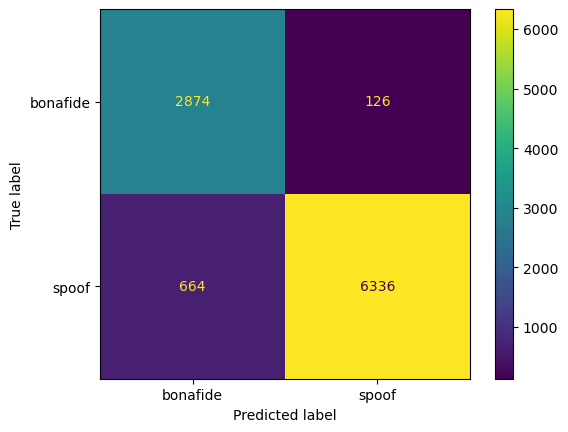

In [362]:
# lets' look at the results from the test set

ypred_test_neq = simple_cnn.predict(X_test_neq)
ypred_test_neq[ypred_test_neq>0.5] = 1
ypred_test_neq[ypred_test_neq<0.5] = 0

# Confusion matrix from the test data
ConfusionMatrixDisplay.from_predictions(Y_test_neq, ypred_test_neq, display_labels = ['bonafide', 'spoof'])
plt.show()

In [364]:
# Let's look at the classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test_neq, ypred_test_neq, target_names=['bonafide', 'spoof']))

              precision    recall  f1-score   support

    bonafide       0.81      0.96      0.88      3000
       spoof       0.98      0.91      0.94      7000

    accuracy                           0.92     10000
   macro avg       0.90      0.93      0.91     10000
weighted avg       0.93      0.92      0.92     10000



Using the imbalanced unseen test data, the **the simple CNN model achieved 0.88 f1-score on bonafide class, 0.94 f1-score on the spoof class and an accuracy of 0.92.** While the metrics of spoof improved, the metrics of bonafide class went down in this case. Relatively the model is doing a good job with the classification of the audio samples.

### ResNet results on imbalanced dataset

313/313 [==============================] - 308s 983ms/step


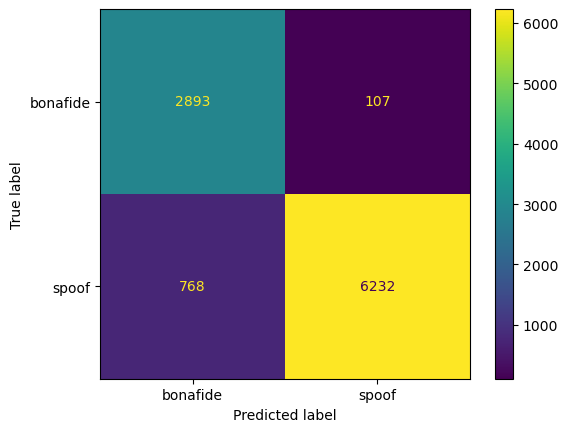

In [370]:
# lets' look at the results from the test set

ypred_test_neq_res = res_cnn.predict(X_test_neq)
ypred_test_neq_res[ypred_test_neq_res>0.5] = 1
ypred_test_neq_res[ypred_test_neq_res<0.5] = 0

# Confusion matrix from the test data
ConfusionMatrixDisplay.from_predictions(Y_test_neq, ypred_test_neq_res, display_labels = ['bonafide', 'spoof'])
plt.show()

In [372]:
# Let's look at the classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test_neq, ypred_test_neq_res, target_names=['bonafide', 'spoof']))

              precision    recall  f1-score   support

    bonafide       0.79      0.96      0.87      3000
       spoof       0.98      0.89      0.93      7000

    accuracy                           0.91     10000
   macro avg       0.89      0.93      0.90     10000
weighted avg       0.93      0.91      0.91     10000



Using the imbalanced unseen test data, the the ResNet model achieved **0.87 f1-score on bonafide class, 0.93 f1-score on the spoof class and an accuracy of 0.91**. The performance of the Resnet model was little lesser than the simple CNN model which was not at all anticipated. Maybe somemore tuning is requried for the ResNet to achieve better results. Maybe a longer number of epochs during training will improve the classification metrics from the ResNet architecture.

### Conclusion
In this project, we utilized a basic CNN model and deep ResNet model for training the ASVSpoof data. Due to computational limitations, the number of epochs of training for the ResNet model was limited to 7. On a balanced data with spoof and bonafide classes, the basic CNN model is achieving an F1-score of 0.92 for both classes, however, the metrics went down for the bonafide class in the imbalanced dataset. The ResNet model acheived similar results on both balanced and imbalanced datasets, but their the classification metrics were slightly lesser than the basic CNN model.